<p align="center">
  <img width="421" alt="comments-toxicity-detection-logo" src="https://user-images.githubusercontent.com/76659596/105877123-eb112280-5fff-11eb-9425-8432e693f92e.png">
</p>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Embedding, Input, Dense,\
    GlobalMaxPooling1D, LSTM, Bidirectional
from sklearn.metrics import roc_auc_score

### Configurations

In [2]:
EMBEDDING_DIMENSION = 100
EMBEDDING_FILE_LOC = '../model/glove/glove.6B.' + str(EMBEDDING_DIMENSION) + 'd.txt'
TRAINING_DATA_LOC = '../data/train.csv'
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2

### Data Preprocessing Steps


#### Import the Pre-Trained Word Vectors
(Link - http://nlp.stanford.edu/data/glove.6B.zip)

In [3]:
word_to_vector = {}
with open(EMBEDDING_FILE_LOC) as file:
    # A space-separated text file in the format
    # word vec[0] vec[1] vec[2] ...
    for line in file:
        word = line.split()[0]
        word_vec = line.split()[1:]

        # converting word_vec into numpy array
        # adding it in the word_to_vector dictionary
        word_to_vector[word] = np.asarray(word_vec, dtype='float32')

    # print the total words found
    print(f'Total of {len(word_to_vector)} word vectors are found.')

Total of 400000 word vectors are found.


#### Import Training Data

In [4]:
training_data = pd.read_csv(TRAINING_DATA_LOC)

#### Explore Training Data

In [5]:
training_data.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [6]:
# Checking the data info for any null entries present
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


#### Split Data into Feature (Comment) and Target Classes

In [7]:
comments = training_data['comment_text'].values
detection_classes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
target_classes = training_data[detection_classes].values

#### Length Information of Comments

In [8]:
# Max and Min Length
print(f'Maximum length of the comments {max(len(s) for s in comments)}')
print(f'Minimum length of the comments {min(len(s) for s in comments)}')

# Median Length
s = sorted(len(s) for s in comments)
print(f'Median length of the comments {s[len(s) // 2]}')

Maximum length of the comments 5000
Minimum length of the comments 6
Median length of the comments 205


#### Convert Comments (Strings) into Integers

In [9]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

#### Word to Integer Mapping

In [10]:
word_to_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_to_index))

Found 210337 unique tokens.


#### Padding Sequences to a N x T Matrix

In [11]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


#### Form the embedding matrix

##### Preparation of Embedding Matrix

In [12]:
num_words = min(MAX_VOCAB_SIZE, len(word_to_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIMENSION))
for word, i in word_to_index.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word_to_vector.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros
      embedding_matrix[i] = embedding_vector

##### Load Pre-Trained Word Embeddings into an Embedding Layer

In [13]:
# Set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### Build the Bidirectional LSTM Model

In [14]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(units=15, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(detection_classes), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Train the Bidirectional LSTM model

In [15]:
rnn_model = model.fit(data,
                      target_classes,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 55s 52ms/step - loss: 0.1688 - accuracy: 0.9747 - val_loss: 0.0637 - val_accuracy: 0.9931

#### Model Evaluation

##### Plot the training and validation loss

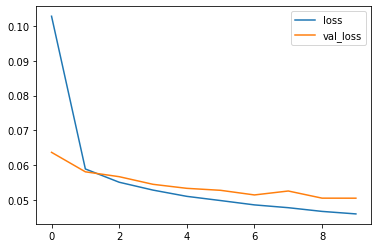

In [16]:
plt.plot(rnn_model.history['loss'], label='loss')
plt.plot(rnn_model.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

##### Plot the training and validation loss

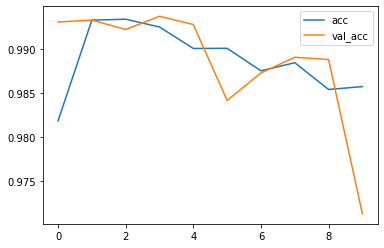

In [17]:
plt.plot(rnn_model.history['accuracy'], label='acc')
plt.plot(rnn_model.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

##### Average ROC_AUC Score

In [18]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(target_classes[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9810303406757632
